In [73]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [74]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [75]:
# Load the training data
all_cities_path = '../../Data/Clean/combined/all_cities_combined.csv'
train_full_df = pd.read_csv(all_cities_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [76]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex', 'DATE', 'CityName']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [77]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [78]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
People25PlusThousands_2019,float64,0.142857,4414.047790,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."
DaysToClose,float64,0.119048,32.000000,25,819,0.6,"Index([32.0, 33.0, 35.0, 37.0, 36.0, 38.0, 34...."
MarketTempIdx,float64,0.042125,53.000000,66,819,0.6,"Index([53.0, 52.0, 56.0, 67.0, 51.0, 55.0, 50...."


In [79]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [80]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [81]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [82]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [83]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [84]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.349140,0.348842,0.999761,0.922068,0.355779,0.367631,0.348805,0.107837
PowerTransformer,0.000039,0.000039,0.000088,0.000088,0.000066,0.000066,0.000039,0.000009
QuantileTransformer,0.484765,0.484507,1.013425,0.979817,0.761519,0.815346,0.484320,0.167189


Note
* HistGradientBoost and Lasso Regression
* RidgeCV with PowerTransformer good, suspiciously good

In [85]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.351929,0.351786,0.979367,0.898866,0.351642,0.351848,0.351786,0.132440
PowerTransformer,0.000039,0.000039,0.000086,0.000086,0.000039,0.000039,0.000039,0.000010
QuantileTransformer,0.505547,0.505454,0.994172,0.958972,0.505152,0.505206,0.505581,0.200542


Note
* HistGradientBoost most consistent top performer
* PowerTransformer results suspicious

In [86]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.351929,0.351786,0.979367,0.898866,0.351642,0.351848,0.351786,0.132440
PowerTransformer,0.000039,0.000039,0.000086,0.000086,0.000039,0.000039,0.000039,0.000010
QuantileTransformer,0.505547,0.505454,0.994172,0.958972,0.505152,0.505206,0.505581,0.200542


Note:
* HistGradientBoost most consistent

## Set the target and feature column tranformers

In [87]:
eda.target_transformer = StandardScaler()
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [88]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
People25PlusThousands_2019,float64,0.142857,4414.047790,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."
DaysToClose,float64,0.119048,32.000000,25,819,0.6,"Index([32.0, 33.0, 35.0, 37.0, 36.0, 38.0, 34...."
MarketTempIdx,float64,0.042125,53.000000,66,819,0.6,"Index([53.0, 52.0, 56.0, 67.0, 51.0, 55.0, 50...."


In [89]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [90]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.88)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.594470,1.339716,7.296549e-18,5.734144,0.015749,0.440737,2.390672
numerical__SalesCount,0.136562,0.564685,6.666773e-03,10.659361,0.058288,0.436635,1.196170
numerical__PctSoldAboveList,0.302563,0.345744,4.674872e-01,59.965592,0.394286,0.072466,1.115059
numerical__NewConstructMeanSalePrice,0.626951,0.205915,2.467042e-01,7.462308,0.206260,0.074848,1.113975
numerical__ListingPriceCutAmt,0.484661,0.102560,5.646518e-01,7.900132,0.338229,0.046458,0.971908


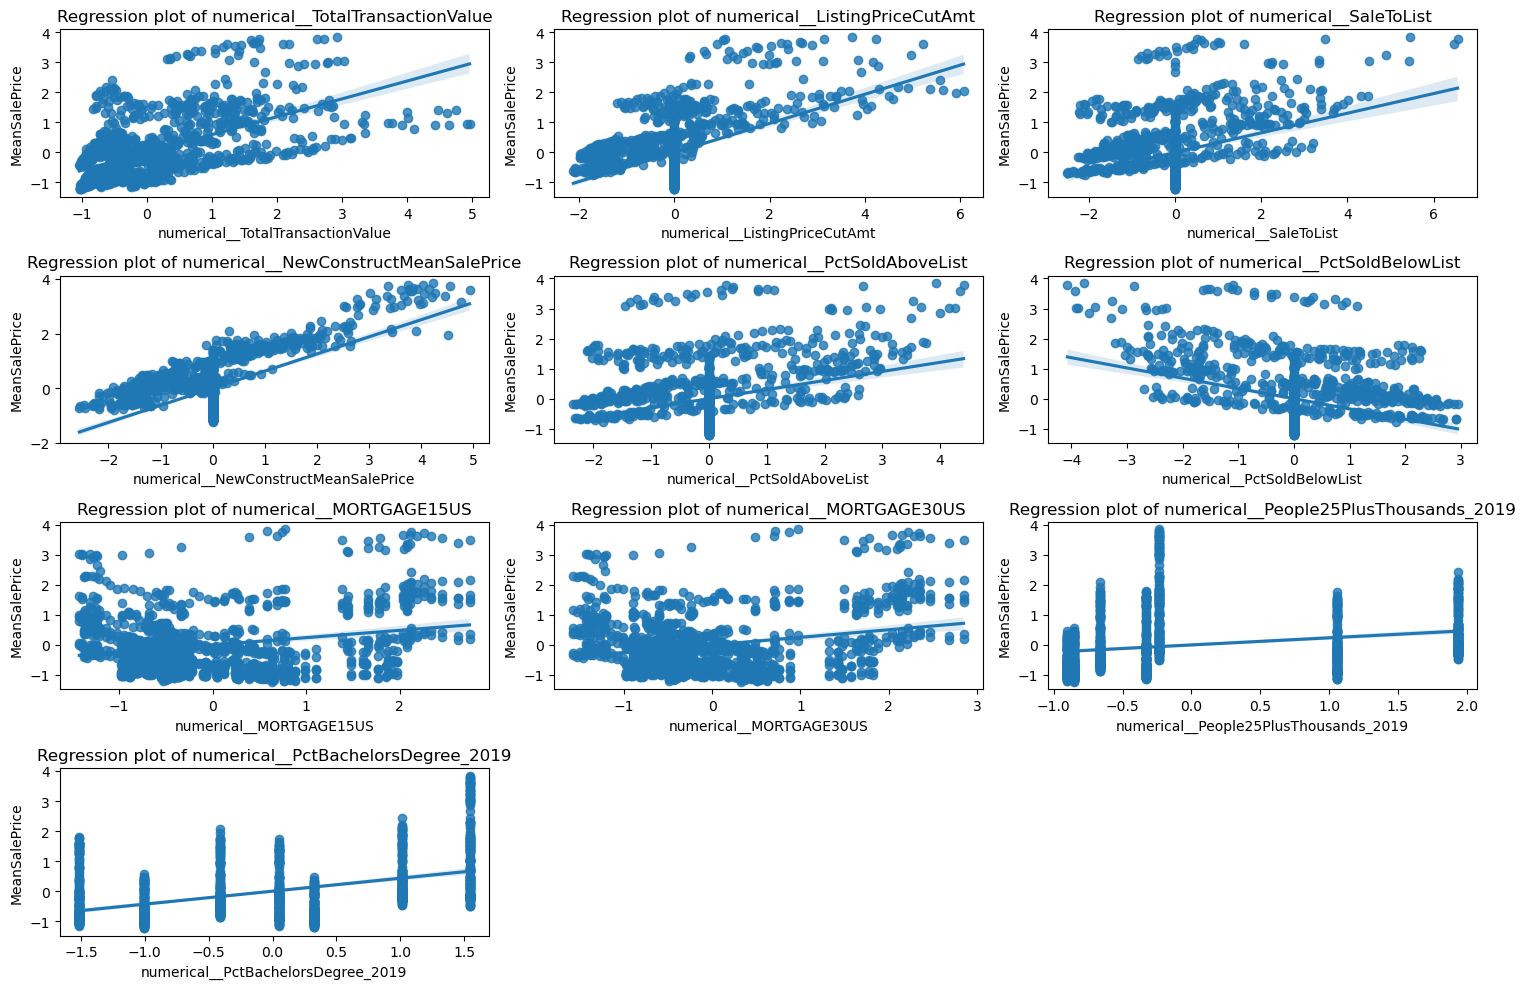

In [91]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

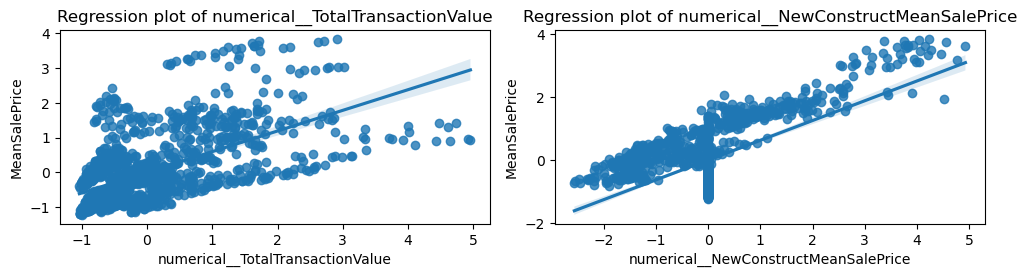

In [92]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 5


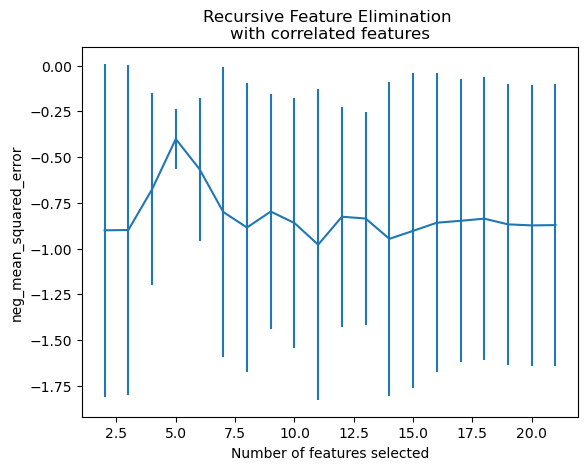

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-1.277873,1.022685,-2.350220,-0.299189,-2.621609,-0.183018,-0.935329,True,1,SalesCount
1,-0.900283,0.909737,-0.646318,-0.216468,-2.615042,-0.085318,-0.938268,True,1,TotalTransactionValue
2,-0.898689,0.903263,-0.666488,-0.192656,-2.601643,-0.107326,-0.925332,False,16,MarketTempIdx
3,-0.676175,0.524109,-0.660861,-0.191935,-1.556181,-0.103884,-0.868015,True,1,DaysToClose
4,-0.400966,0.163475,-0.660863,-0.191961,-0.464077,-0.266795,-0.421135,False,11,DaysOnZillow


In [93]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [94]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'DaysToClose'
 'NewConstructMeanSalePrice' 'NUM_JOBS']


Optimal number of features: 4


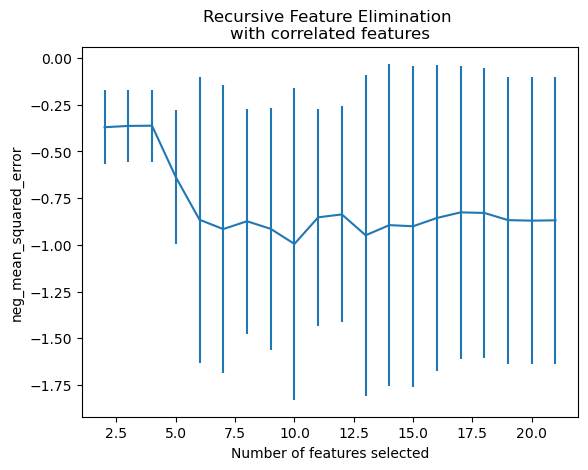

In [95]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [96]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue' 'DaysToClose'
 'NewConstructMeanSalePrice']


In [97]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=6)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 6 features by forward sequential featureselection in 1.011 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'NewConstructMeanSalePrice', 'NewConstructSalesCount', 'MORTGAGE15US', 'PctBachelorsDegree_2019']


In [98]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = sfs_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(sfs_ridge_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(0, [])

## Perform final EDA with selected features and ordinal columns

In [99]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['SalesCount',
                                                                                                     'TotalTransactionValue',
                                                                                                     'NewConstructMeanSalePrice',
                                                                                                     'NewConstructSalesCount',
                                                                                                     'MORTGAGE15US',
                                                                                                     'PctBachelorsDegree_2019'])),
                                                 ('imputer', SimpleImpu...
       'DaysOnZillow', 'ListingPriceCutAmt', 'ListingPriceCutPct',
       'SaleToList', 'NewConstructMeanSalePrice', 'NewConstructSalesCount',
       'PctListingsPriceCut', 'PctSoldAboveList', 'PctSoldBelowList',
       'MORTGAGE15US', 'MORTGAGE30US', 'RATE_DIFFERENCE', 'NUM_JOBS',
       'GROWTH_PCT', 'People25PlusThousands_2019', 'PctHighSchoolDiploma_2019',
       'PctBachelorsDegree_2019'],
      dtype='object'))])

In [100]:
eda.selected_feature_list

['SalesCount',
 'TotalTransactionValue',
 'NewConstructMeanSalePrice',
 'NewConstructSalesCount',
 'MORTGAGE15US',
 'PctBachelorsDegree_2019']

In [101]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.83)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.594470,1.220498,6.560173e-18,4.752342,0.555232,0.323563,2.693762
numerical__NewConstructMeanSalePrice,0.626951,0.198704,1.743909e-02,1.658806,0.115897,0.691124,1.632676
numerical__SalesCount,0.136562,0.689283,1.102153e-06,4.867178,0.608485,0.028960,1.463290
numerical__PctBachelorsDegree_2019,0.430768,0.125782,8.407880e-02,1.263276,0.101351,0.528402,1.186302
numerical__MORTGAGE15US,0.243264,0.096066,1.752494e-01,1.203822,0.152639,0.370711,0.862680


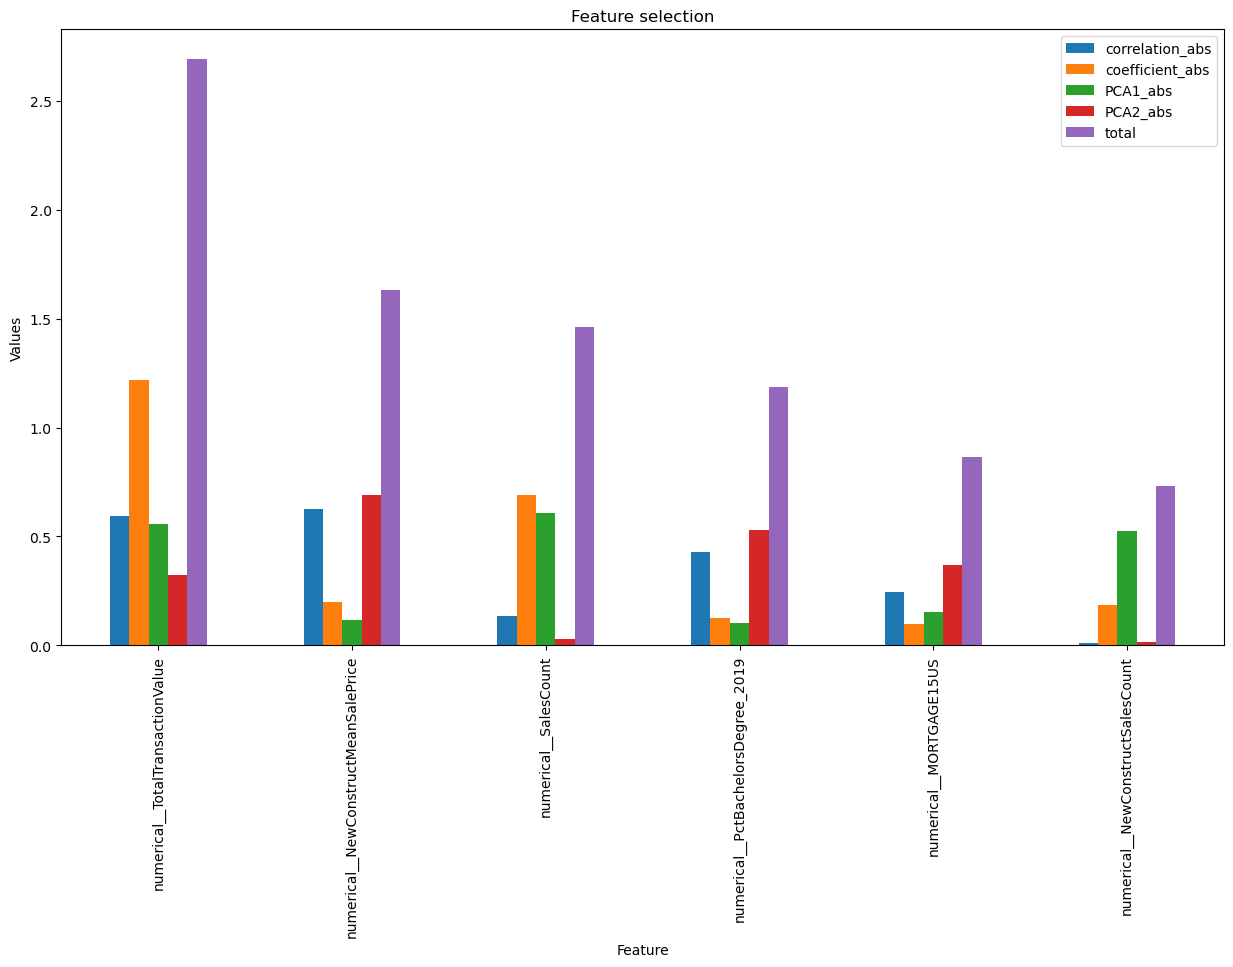

In [102]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [110]:
# Reload the data just to be safe
train_full_df = pd.read_csv(all_cities_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.prune_infreq_numerical = 1.1
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [111]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [112]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 6


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.998104,0.028859,0.969910,0.969231,0.808129,0.037889,1.473191,"[0.2361883278491762, -0.19122166406052177, -0...."
Linear Regression,0.834938,0.168806,0.823995,0.820025,0.808129,0.037889,0.009702,"[-0.1539957021697271, -0.47434173401226976, -0..."
LassoCV,0.834933,0.169100,0.823689,0.819712,0.808129,0.037889,0.049371,"[-0.15360609688541343, -0.47604934676763033, -..."
RidgeCV,0.834927,0.169203,0.823582,0.819602,0.808129,0.037889,0.008592,"[-0.15333761374091906, -0.4784515709762337, -0..."
Ridge Regression,0.834927,0.169203,0.823582,0.819602,0.808129,0.037889,0.008211,"[-0.15333761374105073, -0.47845157097408597, -..."
ElasticNetCV,0.834917,0.169382,0.823395,0.819412,0.808129,0.037889,0.048433,"[-0.1531498822766131, -0.47889384015810815, -0..."


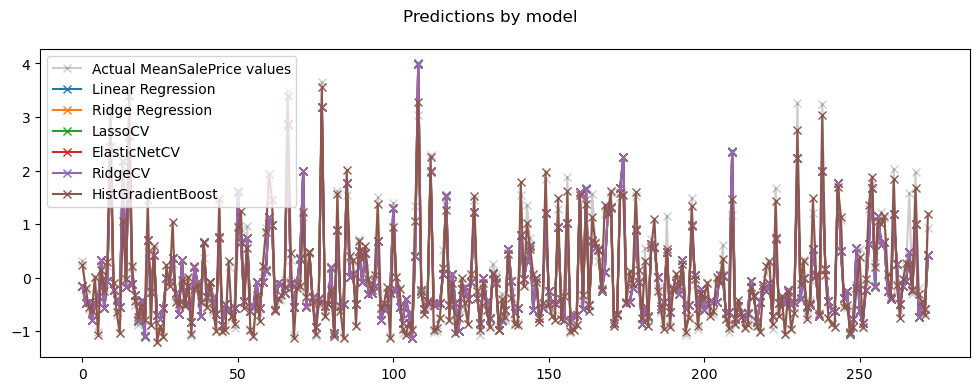

In [113]:
reg.plot_model_evaluations()

* Looks overfit to me

In [114]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Denver Predictions

In [119]:
# Load test data from a different city
denver_path = '../../Data/Clean/combined/Denver_combined.csv'
test_full_df = pd.read_csv(denver_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,245069.0,4305.0,9.275848e+08,239786.727396,243635.279120,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1259.0,1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
1,2008-05-31,242919.0,4779.0,1.043794e+09,240755.620219,242719.130794,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1256.8,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
2,2008-06-30,245529.0,4789.0,1.136320e+09,241296.223700,241952.165191,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1258.2,-0.6,2434.5429,91.688128,49.747029,"DENVER, CO"
3,2008-07-31,247607.0,4922.0,1.195890e+09,240843.494803,240801.464621,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1256.1,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
4,2008-08-31,246384.0,4333.0,1.154412e+09,239424.931087,239672.270501,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1256.2,-0.2,2434.5429,91.688128,49.747029,"DENVER, CO"


In [120]:
# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,4305.0,9.275848e+08,239786.727396,243635.279120,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1259.0,1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
1,2008-05-31,4779.0,1.043794e+09,240755.620219,242719.130794,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1256.8,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
2,2008-06-30,4789.0,1.136320e+09,241296.223700,241952.165191,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1258.2,-0.6,2434.5429,91.688128,49.747029,"DENVER, CO"
3,2008-07-31,4922.0,1.195890e+09,240843.494803,240801.464621,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1256.1,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
4,2008-08-31,4333.0,1.154412e+09,239424.931087,239672.270501,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1256.2,-0.2,2434.5429,91.688128,49.747029,"DENVER, CO"


In [123]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

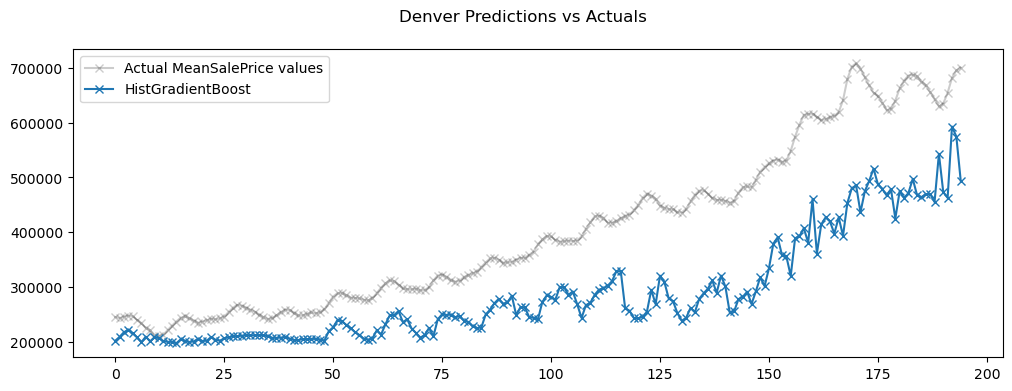

In [124]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Denver Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

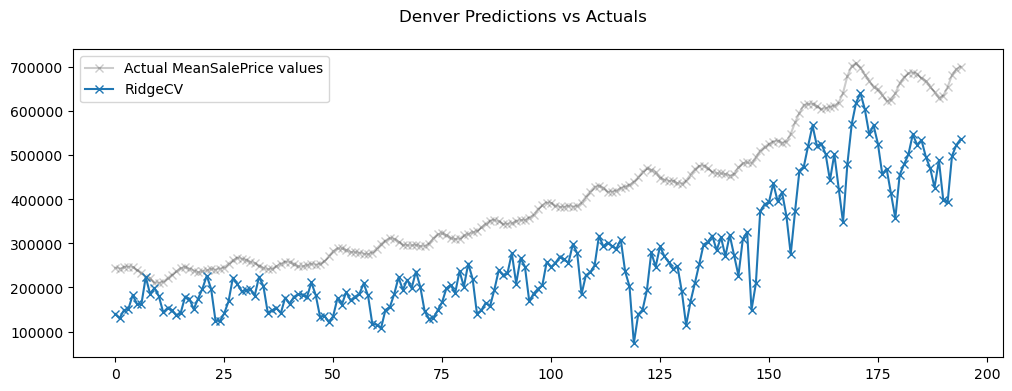

In [125]:
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Denver Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

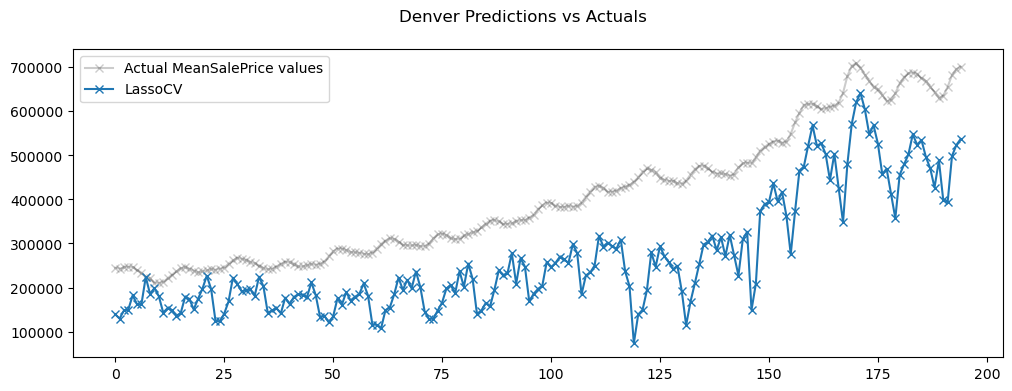

In [126]:
reg.best_model = model_dict['LassoCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Denver Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="LassoCV")
_ = ax.legend()

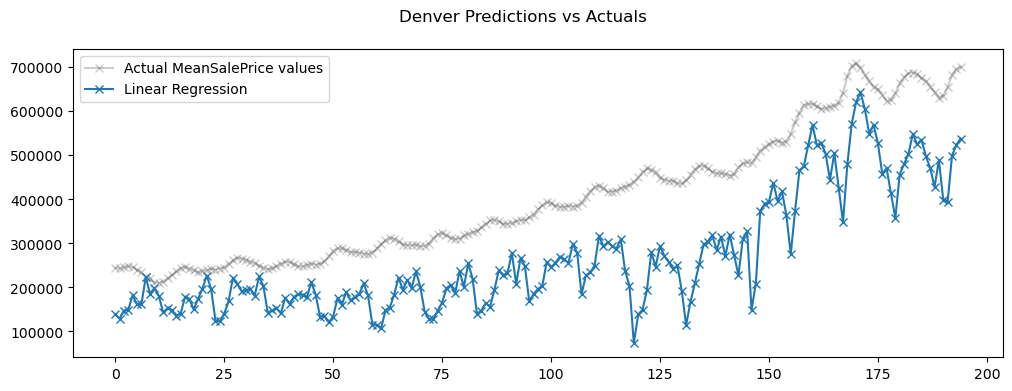

In [127]:
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Denver Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

## Atlanta

In [129]:
# Load test data from a different city
atlanta_path = '../../Data/Clean/combined/Atlanta_combined.csv'
test_full_df = pd.read_csv(atlanta_path)
test_full_df.head()

# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


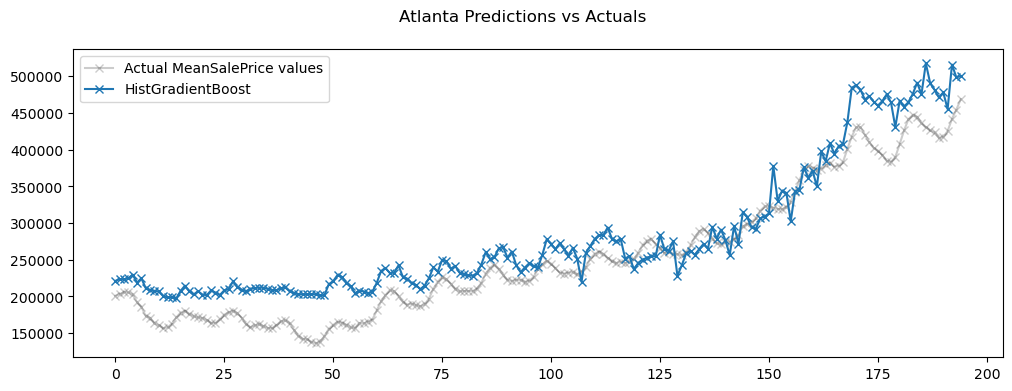

In [130]:
reg.best_model = model_dict['HistGradientBoost']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

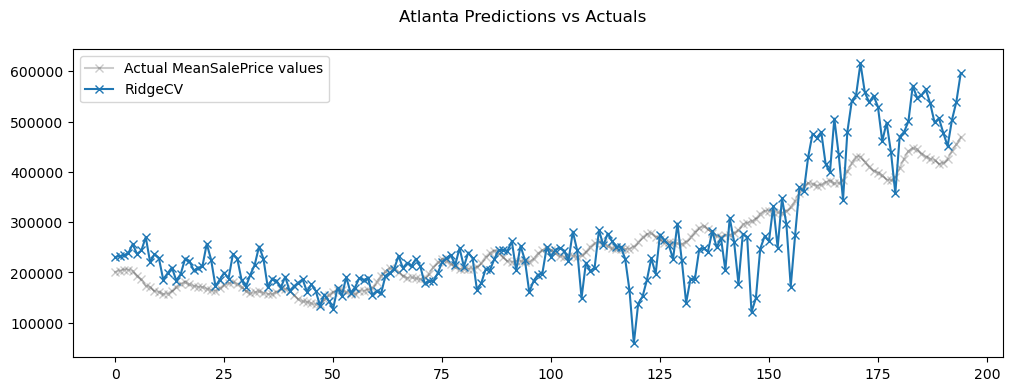

In [131]:
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

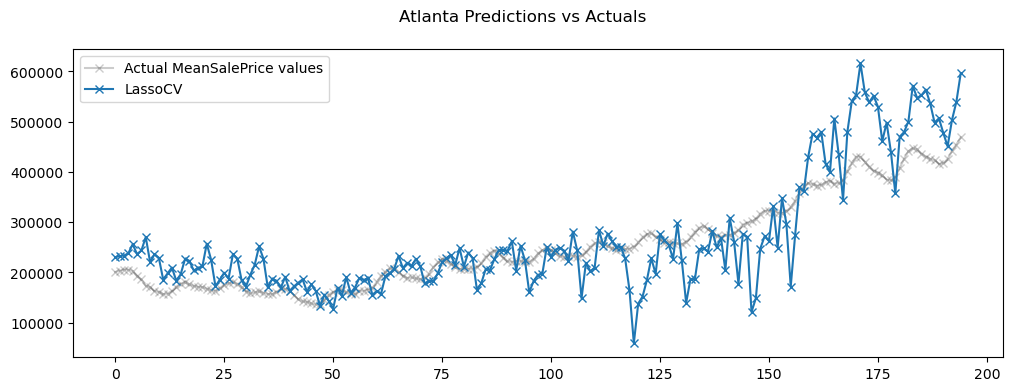

In [132]:
reg.best_model = model_dict['LassoCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="LassoCV")
_ = ax.legend()

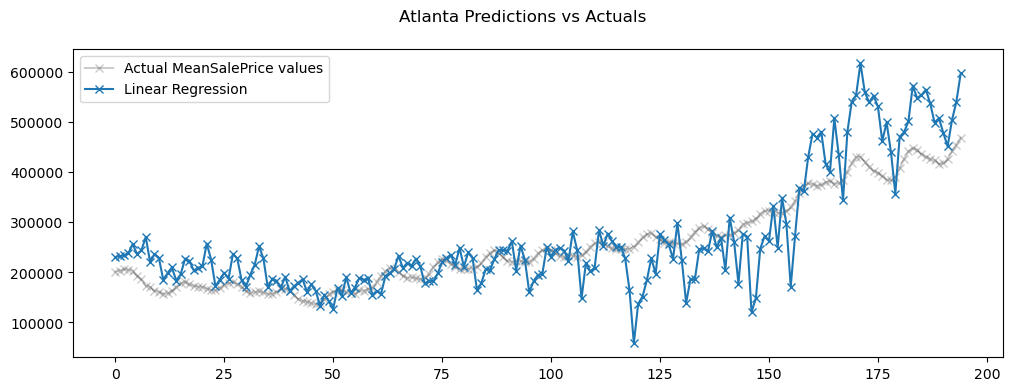

In [133]:
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

## Charlotte

In [134]:
# Load test data from a different city
charlotte_path = '../../Data/Clean/combined/Charlotte_combined.csv'
test_full_df = pd.read_csv(charlotte_path)
test_full_df.head()

# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


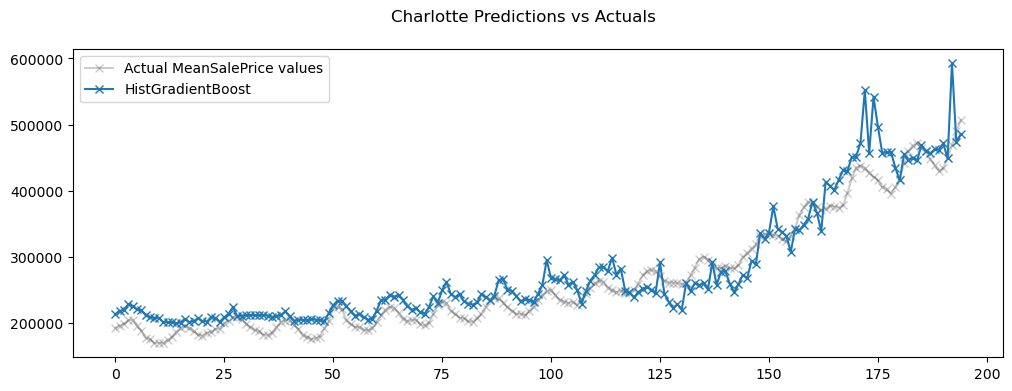

In [136]:
reg.best_model = model_dict['HistGradientBoost']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Charlotte Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

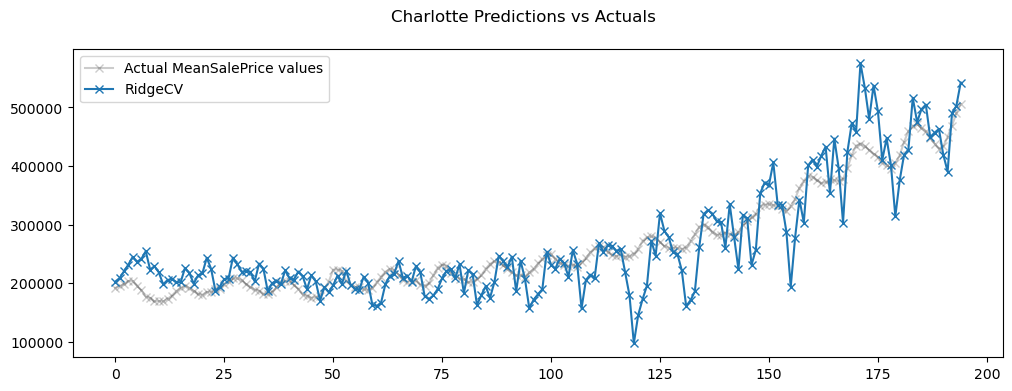

In [137]:
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Charlotte Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

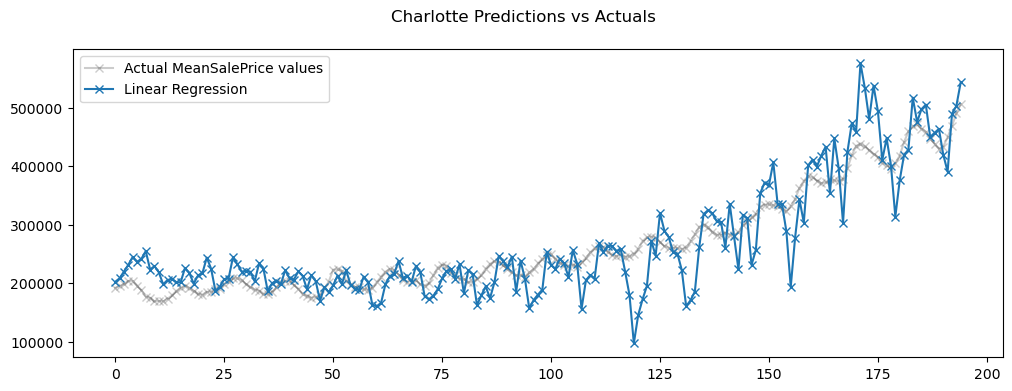

In [138]:
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Charlotte Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

## Cincinnati

In [139]:
# Load test data from a different city
cincinnati_path = '../../Data/Clean/combined/Cincinnati_combined.csv'
test_full_df = pd.read_csv(charlotte_path)
test_full_df.head()

# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


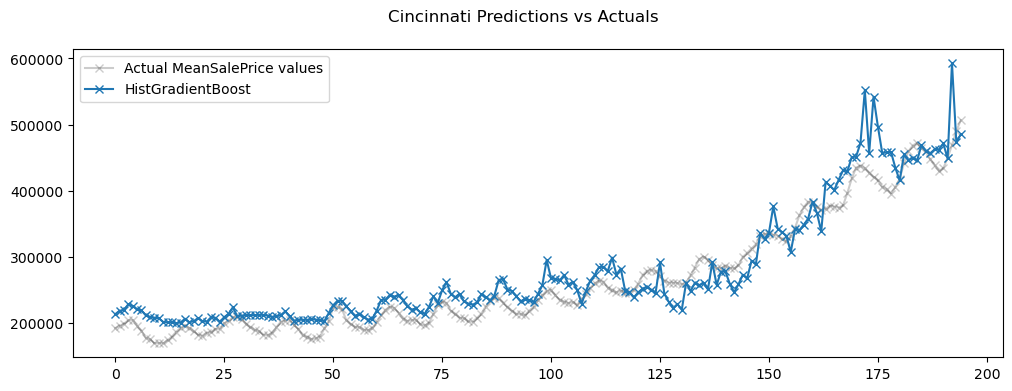

In [140]:
reg.best_model = model_dict['HistGradientBoost']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cincinnati Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

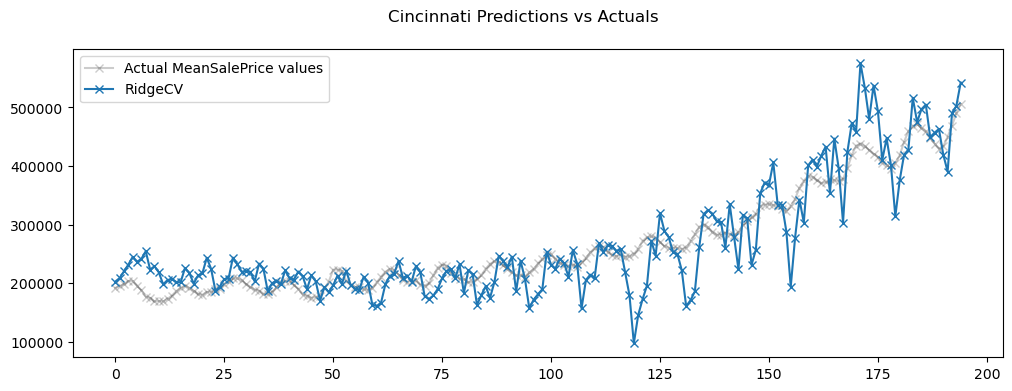

In [141]:
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cincinnati Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

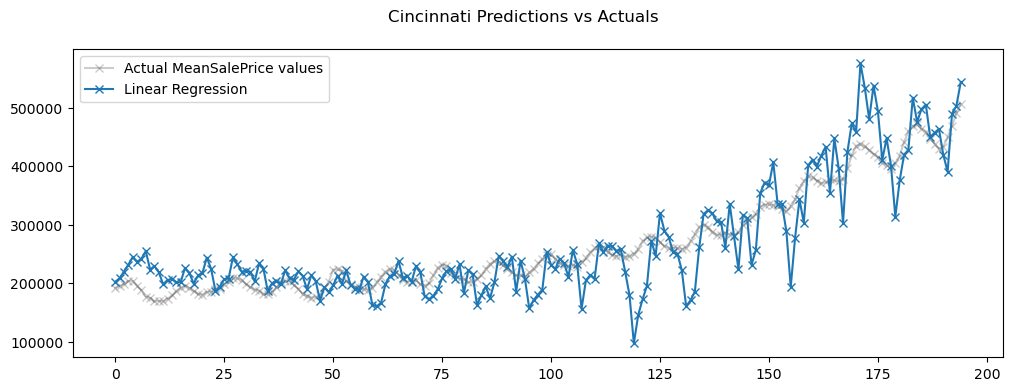

In [142]:
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cincinnati Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

## Indianapolis

In [144]:
# Load test data from a different city
indi_file_path = '../../Data/Clean/combined/Indianapolis_combined.csv'
test_full_df = pd.read_csv(charlotte_path)
test_full_df.head()

# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


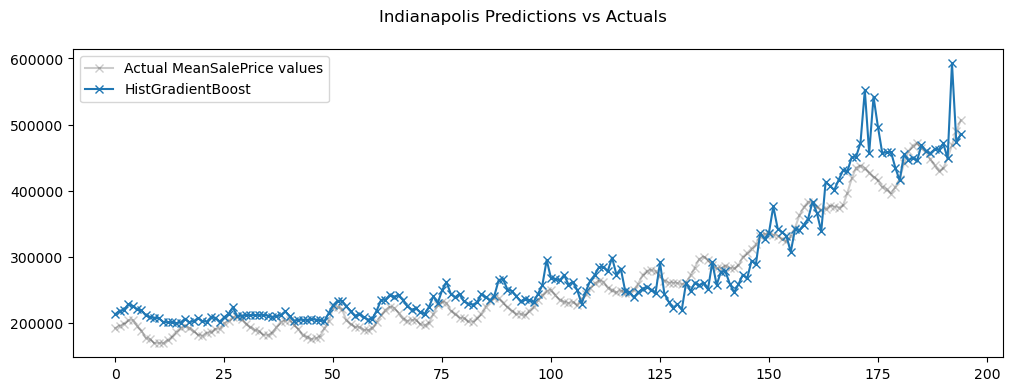

In [145]:
reg.best_model = model_dict['HistGradientBoost']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Indianapolis Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()

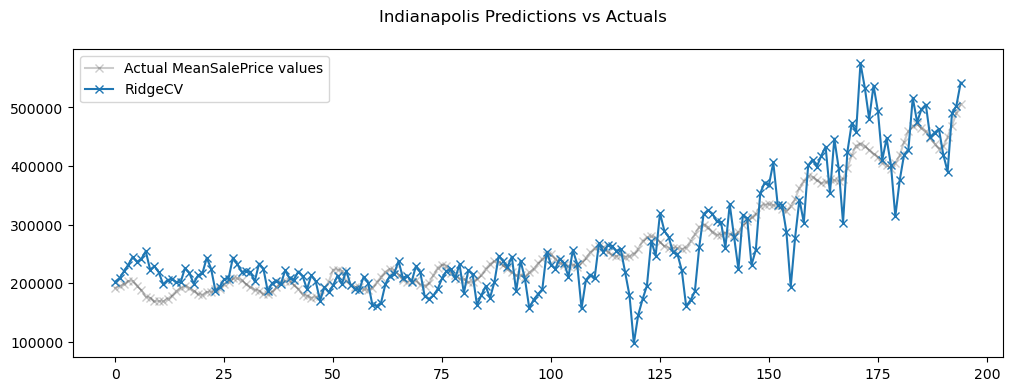

In [146]:
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Indianapolis Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

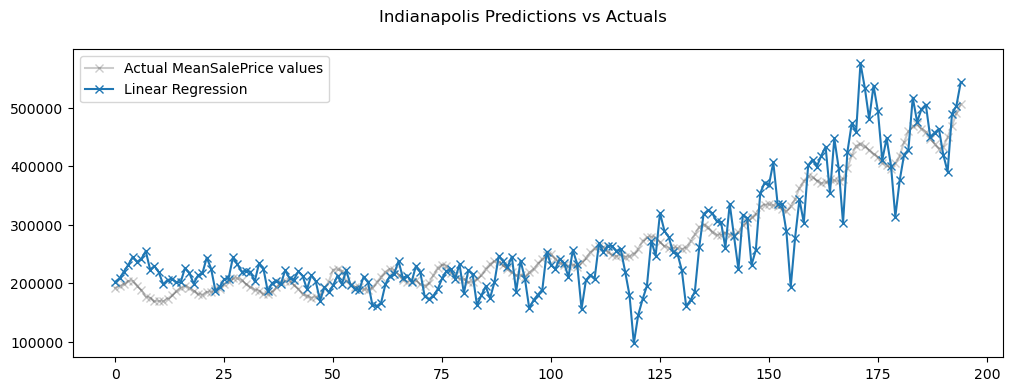

In [147]:
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Indianapolis Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

## Providence

In [148]:
# Load test data from a different city
prov_file_path = '../../Data/Clean/combined/Providence_combined.csv'
test_full_df = pd.read_csv(charlotte_path)
test_full_df.head()

# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


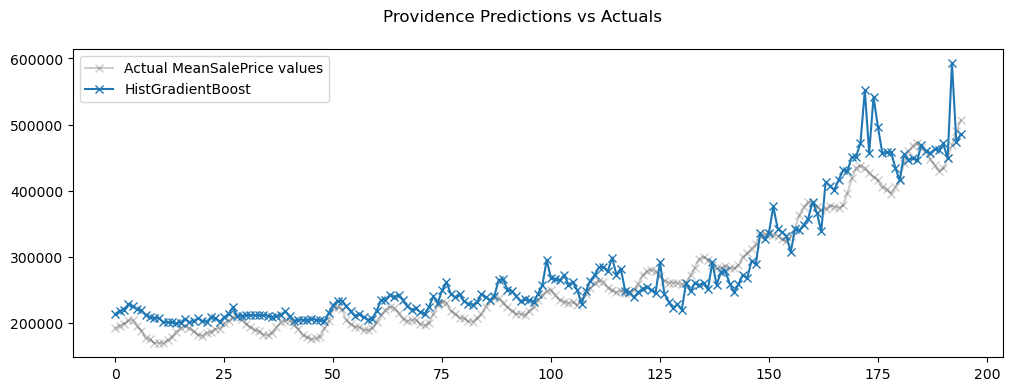

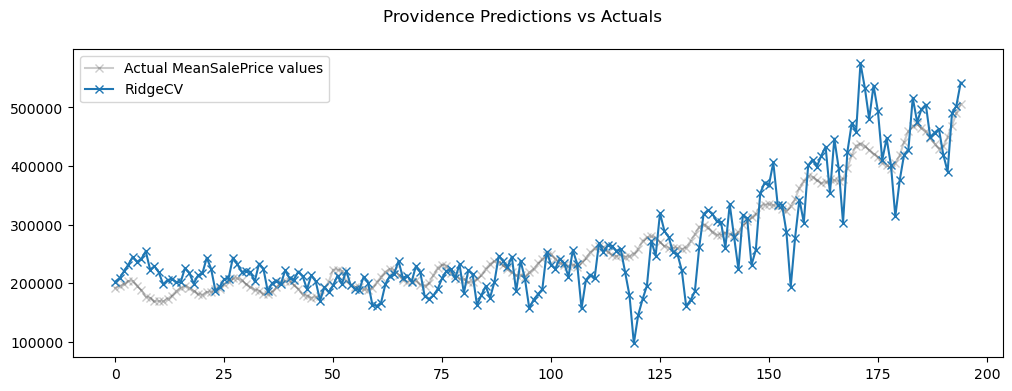

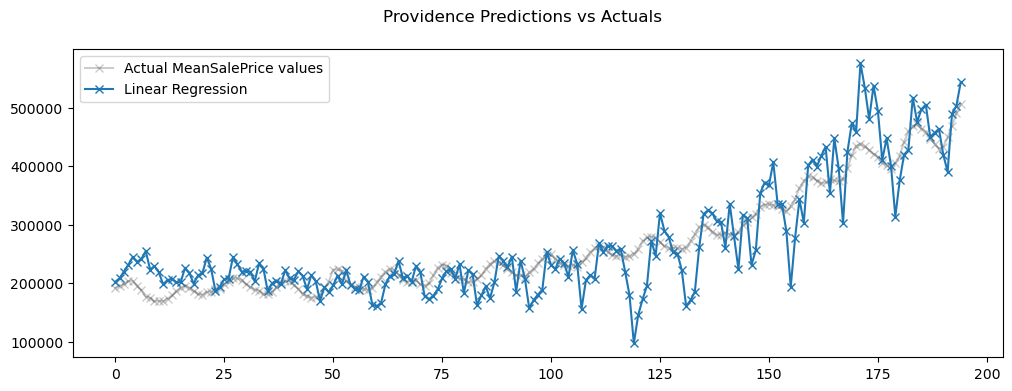

In [150]:
#HistGradientBoost
reg.best_model = model_dict['HistGradientBoost']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Providence Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()


# RidgeCV
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Providence Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

# Linear Regression
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Providence Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()

## Tampa

In [151]:
# Load test data from a different city
tampa_file_path = '../../Data/Clean/combined/Tampa_combined.csv'
test_full_df = pd.read_csv(charlotte_path)
test_full_df.head()

# Drop target column
actual_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,2856.0,503313664.0,178716.688988,181743.275129,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1027.8,-1.2,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
1,2008-05-31,2962.0,548334302.0,179423.191080,181545.123492,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1026.8,-2.0,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
2,2008-06-30,2963.0,581541816.0,179464.810356,181053.563638,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1026.1,-1.3,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
3,2008-07-31,2845.0,595760175.0,179255.088378,180331.749481,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1024.6,-1.1,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"
4,2008-08-31,2530.0,568197072.0,178753.302909,179487.604132,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1024.7,-0.7,1777.64019,91.950313,39.434102,"CHARLOTTE, NC"


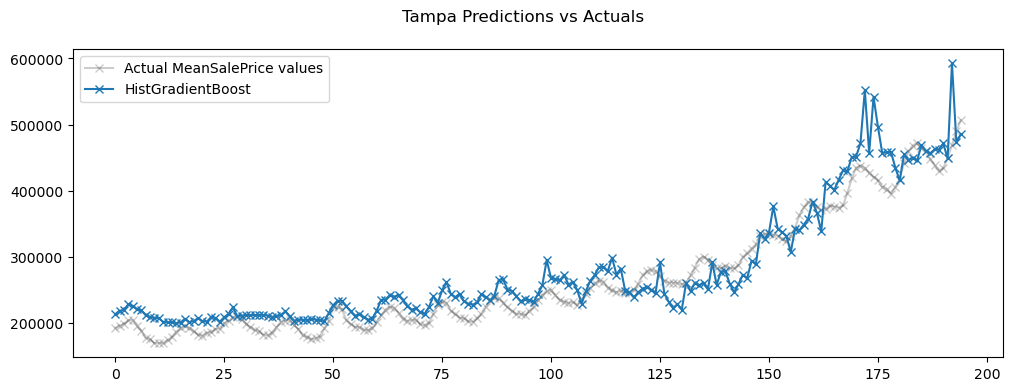

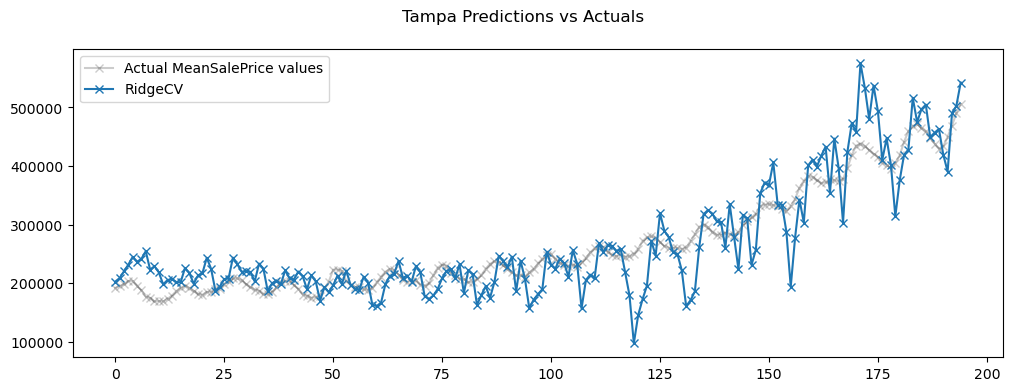

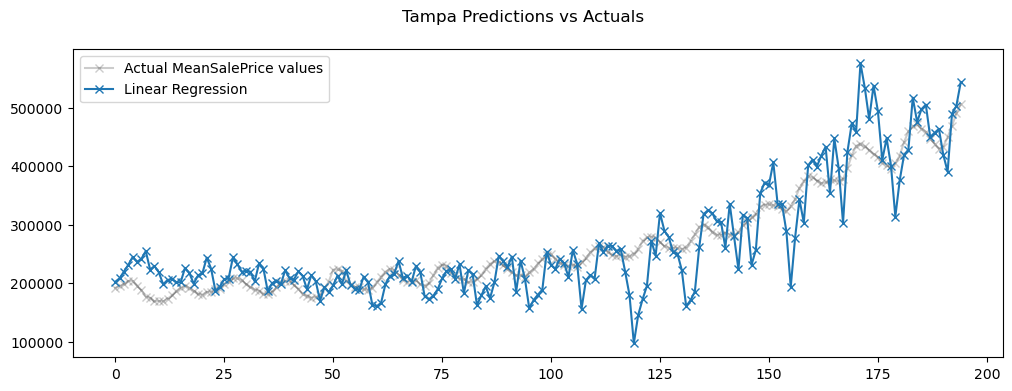

In [152]:
#HistGradientBoost
reg.best_model = model_dict['HistGradientBoost']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Tampa Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()


# RidgeCV
reg.best_model = model_dict['RidgeCV']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Tampa Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="RidgeCV")
_ = ax.legend()

# Linear Regression
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Tampa Predictions vs Actuals")
ax.plot(
    actual_df,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="Linear Regression")
_ = ax.legend()